# Telco Churn Classification Project

In [1]:
# standard ds imports
import numpy as np
import pandas as pd

# for wrangling and exploration
import acquire
import prepare
import explore
import model

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# for statistical analysis
import scipy.stats as stats

# for model evaluation
import sklearn.metrics as met
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

#filter out noise
import warnings
warnings.filterwarnings('ignore')

## 1. Planning

 - Create README, final_report.ipynb, working_report.ipynb
 - Bring over functional acquire.py, prepare.py, explore.py, and model.py files
 - Acquire the data from the Code Up database via the acquire.py function
 - Prepare and split the data via the prepare.py functions
 - Explore the data and define hypothesis. Run the appropriate statistical tests in order to accept or reject each null hypothesis. Document findings and takeaways.
 - Create a baseline model in predicting churn and document the accuracy.
 - Fit and train three (3) classification models to predict churn on the train dataset.
 - Evaluate the models by comparing the train and validation data.
 - Select the best model and evaluate it on the train data.
 - Create a predictions csv for each observation in the test dataset using the best model's predictions. The csv should include the customer id, probability of staying, probability of churning, and prediction of churn.
 - Develop and document all findings, takeaways, recommendations and next steps. 

## Executive Summary:

- The classification models created (Logistic Regression, Random Forest, and KNeighbors) produced varying levels of accuracy and recall. Every model beat the baseline accuracy and would better predict churn. 
- Due to wanting to capture every possible customer churning, the best model is the model that maximizes recall. The Logistic Regression model produced the best results at 79% recall.
- With more time, I predict feature engineering data to show time from subscribing to fiber optic to time of churn would increase the model's recall rate.

- I recommend evaluating fiber optic customers' experience early and often. My best model evaluated the fiber optic feature to have a weight of 2.78 (the closer to 1, the less impact on churn), over twice the next highest coefficient in the model's decision function.

## 2. Data Acquisition

#### Data Dictionary
----

| Target | Type | Description |
| ---- | ---- | ---- |
| churn | int | 0 if the customer is still with the company, 1 if they have left/churned |

-----

| Feature Name | Type | Description |
| ---- | ---- | ---- |
| contract_type | int | 12 for month-to-month contract, 1 for 1 year contract, 2 for 2 year contract |
| customer_id | object | individual customer identifier |
| DSL | int | 0 if the customer does not have DSL, 1 if they do |
| extras | int | count of add-on services the customer is subscribed to (online security, online backup, device protection, tech support, streaming tv, streaming movies) | 
| Fiber optic | int | 0 if the customer does not have fiber optic, 1 if they do |
| monthly_charges | float | price of monthly services charged to the customer each month |
| paperless_billing | int | 0 if customer does not have paperless billing, 1 if they do |
| senior_citizen | int | 0 for non-senior citizen customers, 1 for senior citizens |
| tenure | int  | years customer has been with telco |

In [2]:
# Acquire the data
telco = acquire.get_telco_data()

In [3]:
# Look at it's rows and columns (observations and features)
telco.shape

(7043, 24)

### Acquisition Takeaways

- I utilized my get_telco_data function from my acquire.py file. This function grabs the data from the CodeUp database via a SQL query.
- This function also created a local csv for ease of future use.
- The telco data brings in 24 columns of data over 7043 observations.
- Foreign key columns are creating duplicates. These will be cleaned in the next phase.

## 3. Data Preparation

In [4]:
# Prepare the data
telco = prepare.prep_telco(telco)

In [5]:
# Look at the datatypes and ensure there are no lingering nulls. 
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_id                7043 non-null   object 
 1   gender                     7043 non-null   int64  
 2   senior_citizen             7043 non-null   int64  
 3   partner                    7043 non-null   int64  
 4   dependents                 7043 non-null   int64  
 5   tenure                     7043 non-null   int64  
 6   phone_service              7043 non-null   int64  
 7   multiple_lines             7043 non-null   int64  
 8   online_security            7043 non-null   int64  
 9   online_backup              7043 non-null   int64  
 10  device_protection          7043 non-null   int64  
 11  tech_support               7043 non-null   int64  
 12  streaming_tv               7043 non-null   int64  
 13  streaming_movies           7043 non-null   int64

In [6]:
# Split the data into the datasets. 60% for train, 20% for validate, and 20% for test.
train, val, test = prepare.split_data(telco, 'churn')

In [7]:
# Check the shapes to ensure the split executed as expected
train.shape, val.shape, test.shape

((4225, 25), (1409, 25), (1409, 25))

In [8]:
# Feature engineer 'extras', a count of the add-on services available. 
train['extras'] = train['online_security'] + train['online_backup']+train['device_protection']+train['tech_support']+ train['streaming_tv']+train['streaming_movies']
train = train.drop(columns=['online_security', 'online_backup', 'device_protection','tech_support','streaming_tv','streaming_movies'])

val['extras'] = val['online_security'] + val['online_backup']+val['device_protection']+val['tech_support']+ val['streaming_tv']+val['streaming_movies']
val = val.drop(columns=['online_security', 'online_backup', 'device_protection','tech_support','streaming_tv','streaming_movies'])

test['extras'] = test['online_security'] + test['online_backup']+test['device_protection']+test['tech_support']+ test['streaming_tv']+test['streaming_movies']
test = test.drop(columns=['online_security', 'online_backup', 'device_protection','tech_support','streaming_tv','streaming_movies'])

### Preparation Takeaways

- I utilized my prep_telco function from my prepare.py file. This function:
    - handles nulls (there were none)
    - drops the foreign id columns
    - casts monetary columns to floats
    - enumerates columns's data for ease of exploration and modeling (See Data Dictionary above or in README for details.)
- I feature engineered a column named 'extras'. This column contains a count of all add-on subscriptions customers may add. The amount of extras may play a role in churn. More to be explored in the next step. 
- Before moving to exploration, I split the data in train, validate, and test datasets; these were stratified for the target: churn.

## 4. Data Exploration

In [9]:
# Create lists of the numerical features and the categorical features
nums = ['monthly_charges', 'total_charges']
cats = ['extras','senior_citizen', 'multiple_lines', 'gender', 'partner', 'dependents', 'phone_service','paperless_billing','churn','contract_type','DSL', 'Fiber optic', 'Bank transfer (automatic)','Credit card (automatic)','Electronic check','Mailed check']

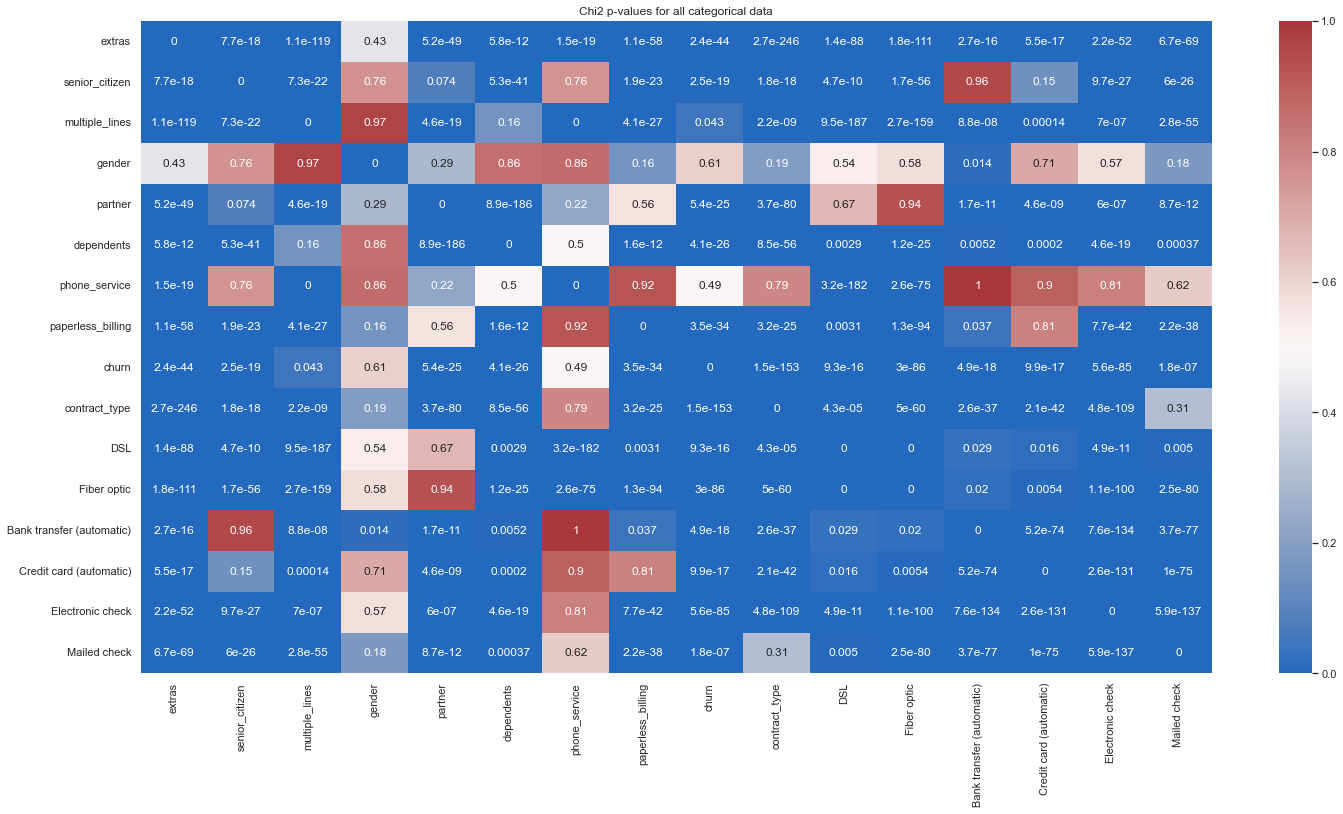

In [10]:
# Check out if each of the categorical functions has an associate with the other categorical features.
c = []
for col in cats:
    d = []
    for spot in cats:
        alpha = 0.05
        o = pd.crosstab(train[col], train[spot])
        chi2, p, dof, e = stats.chi2_contingency(o)
        d.append(p)
    c.append(d)
c = pd.DataFrame(c)
plt.figure(figsize=(24,12))
sns.heatmap(c, xticklabels=cats, yticklabels=cats, annot=True, fmt='.2g', cmap='vlag')
plt.title('Chi2 p-values for all categorical data')
plt.show()

### Question 1: Does monthly charges drive churn?

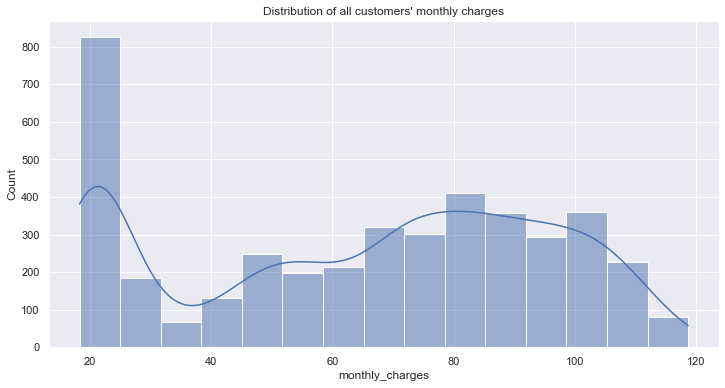

In [11]:
# Make the plot larger
plt.figure(figsize=(12,6))
# Plot it as a histogram with distribution line
sns.histplot(data=train, x='monthly_charges', kde=True)
# Give it a title
plt.title("Distribution of all customers' monthly charges")
plt.show()

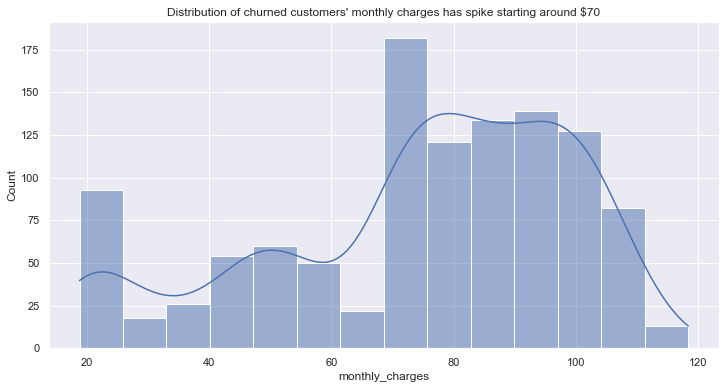

In [12]:
# Make the plot larger
plt.figure(figsize=(12,6))
# Plot it as a histogram with a distribution line
sns.histplot(data=train[train.churn == 1], x='monthly_charges', kde=True)
# Give it a title
plt.title("Distribution of churned customers' monthly charges has spike starting around $70")
plt.show()

#### Hypothesis 1 - Monthly Charges:

    Ho -> The mean of monthly charges for churned customers is less than or equal to the mean of customers that have not churned
    Ha -> The mean of monthly charges for churned customers greater than the mean of customers that have not churned

Two sample, one tail
T-Test of churn vs not churn monthly charges

In [13]:
# create the samples
stayed = train[train.churn == 0]
churned = train[train.churn == 1]

# set alpha
α = 0.05

# check for equal variances
stat, p = stats.levene(churned.monthly_charges, stayed.monthly_charges)

# evaluate variances based on p value
if p < α:
    print('''The two samples have differing variances.
Set equal_var to FALSE on t-test.''')
else:
    print('''The two samples have similar variances.
Proceed with t-test as normal.''')
print(' ')

The two samples have differing variances.
Set equal_var to FALSE on t-test.
 


In [14]:
# run the two-sample, one-tail T-Test
t, p = stats.ttest_ind(churned.monthly_charges, stayed.monthly_charges, equal_var = False)

# evaluate results based on the t-statistic and the p-value
if ((t > 0) & (p/2 < α)):
    print('''Reject the Null Hypothesis.
Findings suggest the average monthly charge of a churned customer is higher than customers that have not. ''')
else:
    print('''Fail to reject the Null Hypothesis.
Findings suggest the average monthly charge of a churned customer is equal to or less than customers that have not.''')
print()

Reject the Null Hypothesis.
Findings suggest the average monthly charge of a churned customer is higher than customers that have not. 



#### Question 1 Takeaways:
- There is a relationship with higher monthly charges and churn.
- There is a spike in churn starting around $70 per month in charges. 

Is there another feature causing this spike in monthly charges?

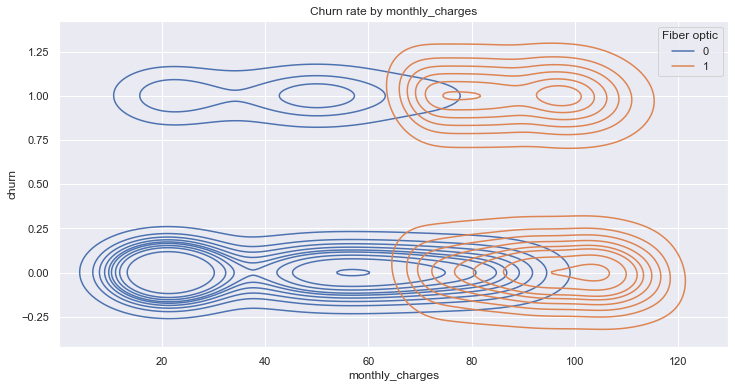

In [15]:
# Make the plot larger
plt.figure(figsize=(12,6))
# Plot it as a kdeplot, isolating fiber optic customers vs non-fiber optic customers
sns.kdeplot(data=train, x='monthly_charges', y='churn', hue='Fiber optic')
# Give it a title
plt.title('Churn rate by monthly_charges')
plt.show()

-----

### Question 2: Does fiber optic drive churn?

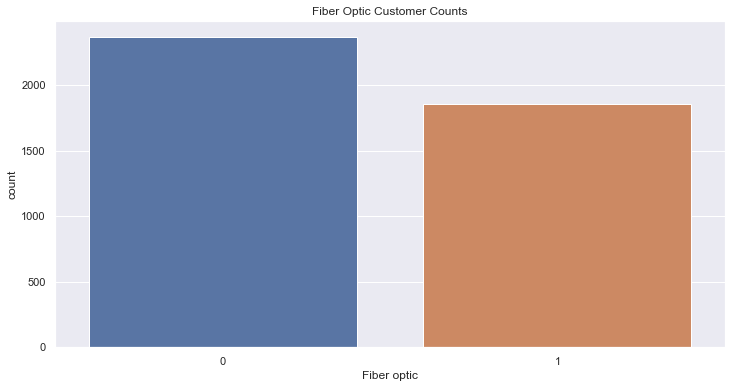

2370 customers or 56.1% do not have fiber optic.
1855 customers or 43.9% have fiber optic.

---------------------------------------------------------------------------------------------------------------



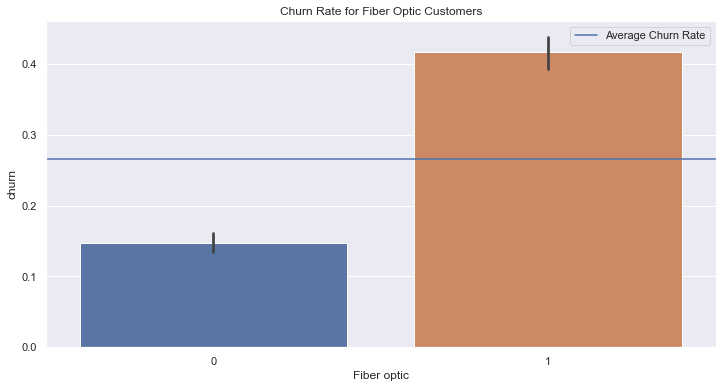

14.7% of all customers without fiber optic churn.
41.7% of all customers with fiber optic churn.


In [16]:
# plot the count of customers in the train dataset against the fiber optic feature
plt.figure(figsize=(12,6))
sns.countplot(x='Fiber optic', data=train)
plt.title('Fiber Optic Customer Counts')
plt.show()

# calculate the count of customers with and without fiber optic
no_fo = train[['Fiber optic']].value_counts()[0]
yes_fo = train[['Fiber optic']].value_counts()[1]

# calculate the percentage of customers with and without fiber optic
no_fo_per = round((train[['Fiber optic']].value_counts(normalize=True)*100)[0], 1)
yes_fo_per = round((train[['Fiber optic']].value_counts(normalize=True)*100)[1], 1)

# print the previously calculated values in statements
print(f'{no_fo} customers or {no_fo_per}% do not have fiber optic.')
print(f'{yes_fo} customers or {yes_fo_per}% have fiber optic.')

# make some space between graphs
print('')
print('---------------------------------------------------------------------------------------------------------------')
print('')

# plot the feature fiber optic against the target of churn
plt.figure(figsize=(12,6))
sns.barplot(data=train, x='Fiber optic', y='churn')
# add a line for average rate of churn in the train data set (regardless of features)
rate = train.churn.mean()
plt.axhline(rate, label= 'Average Churn Rate')
plt.legend()
plt.title('Churn Rate for Fiber Optic Customers')
plt.show()

# calculate the churn rate for customers with and without fiber optic
yes_churn_fo_per = round(((train[(train['Fiber optic']==1)&(train.churn)==1].shape[0]) / (train[train['Fiber optic'] == 1].shape[0]))*100, 1)
no_churn_fo_per = round(((train[(train['Fiber optic']==0)&(train.churn)==1].shape[0]) / (train[train['Fiber optic'] == 0].shape[0]))*100, 1)

# print the previous calulations in statements
print(f'{no_churn_fo_per}% of all customers without fiber optic churn.')
print(f'{yes_churn_fo_per}% of all customers with fiber optic churn.')

#### Hypothesis 2 - Fiber Optic:

    Ho -> There is no association between a customer having fiber optic and a customer churning
    Ha -> There is an association between a customer having fiber optic and a customer churning

##### Chi Square Test: Fiber Optic vs Churn

In [17]:
# create observed dataset
observed = pd.crosstab(train['Fiber optic'], train.churn)

# set alpha to 0.05 (due to 95% confidence level)
α = 0.05

observed

churn,0,1
Fiber optic,,
0,2022,348
1,1082,773


In [18]:
# run chi square test
chi2, p, dof, expected = stats.chi2_contingency(observed)

# evaluate results with the p-value
if p < α:
    print('''Reject the null hypothesis.
    Findings suggest there is an association between a customer having fiber optic and a customer churning.''')
else:
    print('''Fail to reject the null hypothesis.
    Findings suggest there is no association between a customer having fiber optic and a customer churning.''')
print()

Reject the null hypothesis.
    Findings suggest there is an association between a customer having fiber optic and a customer churning.



#### Question 2 Findings:
- Findings suggest there is an association between a customer having fiber optic and a customer churning.
- 41.7% of customers with fiber optic have churned
- Customers with fiber optic churn over twice as much as customers without fiber optic.

### Question 3: Is tenure a driver of churn?

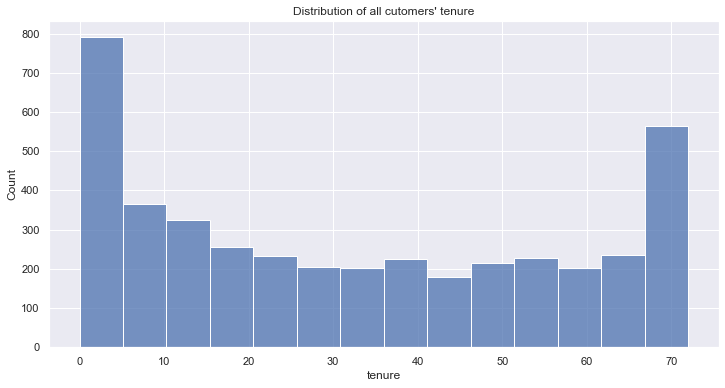

In [19]:
# Make the plot larger
plt.figure(figsize=(12,6))
# Plot it as a histogram
sns.histplot(data=train, x='tenure')
# Give it a title
plt.title("Distribution of all cutomers' tenure")
plt.show()

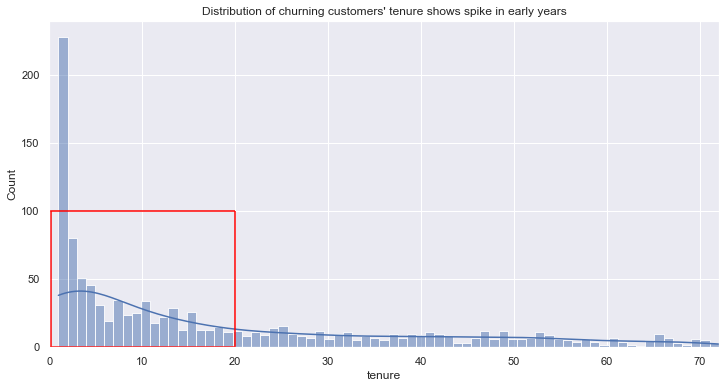

In [20]:
# Make the plot larger
plt.figure(figsize=(12,6))
# Plot it as a histogram with a distribution line, create one bar per year
sns.histplot(data=train[train.churn == 1], x='tenure', kde=True, bins=72)
plt.xlim(0,72)
# Create a box on where we are going in the next graph
plt.hlines(100,0,20, colors='red')
plt.hlines(.2,0,20, colors='red')
plt.vlines(.2,0,100, colors='red')
plt.vlines(20,0,100, colors='red')
# Give it a title
plt.title("Distribution of churning customers' tenure shows spike in early years")
plt.show()

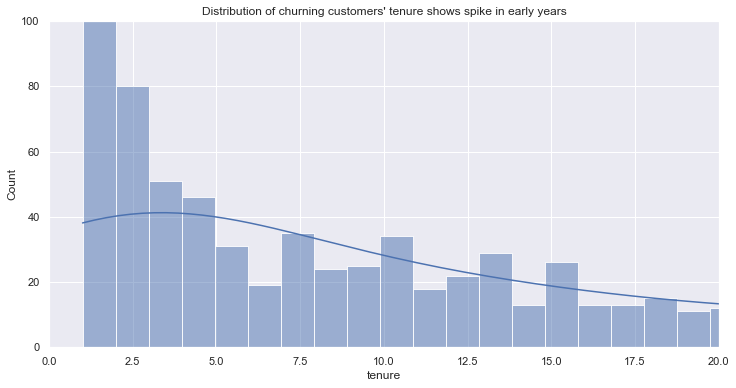

In [21]:
# Make the plot larger
plt.figure(figsize=(12,6))
# Plot it as a histogram with a distribution line, create one bar per year
sns.histplot(data=train[train.churn == 1], x='tenure', kde=True, bins=72)
# Zoom into the box from the previous histogram
plt.xlim(0,20)
plt.ylim(0,100)
# Give it a title
plt.title("Distribution of churning customers' tenure shows spike in early years")
plt.show()

#### Hypothesis 3 - Tenure:

    Ho -> There is not an association between tenure and churn
    Ha -> There is an association between tenure and churn

In [22]:
# create observed data
observed = pd.crosstab(train.tenure, train.churn)

# set alpha with 95% confidence
α = 0.05

# run the chi-square test
chi2, p, dof, expected = stats.chi2_contingency(observed)

# evaluate results with the p-value
if p < α:
    print('''Reject the null hypothesis.
    Findings suggest there is an association between tenure and churning.''')
else:
    print('''Fail to reject the null hypothesis.
    Findings suggest there is no association between tenure and churning.''')
print()

Reject the null hypothesis.
    Findings suggest there is an association between tenure and churning.



#### Question 3 Findings:
- Findings suggest there is an association between tenure and churning.
- The most churn happens between year 0 and year 15.

### Bring all three drivers together

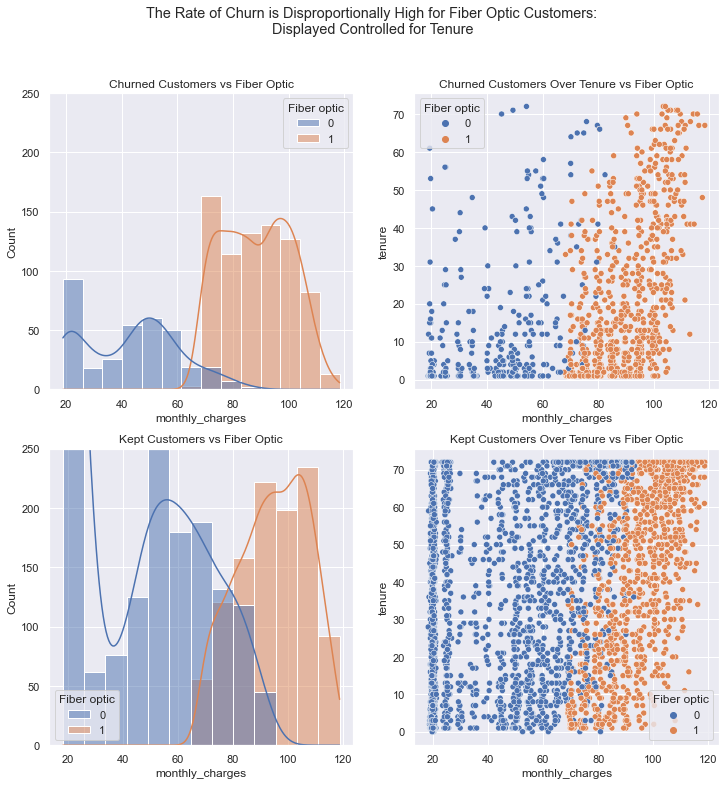

In [23]:
# Create subplot framework
fig, axes = plt.subplots(2,2, figsize=(12,12))
# Give the whole thing a title
fig.suptitle('''The Rate of Churn is Disproportionally High for Fiber Optic Customers: 
Displayed Controlled for Tenure''')

# Give titles to each smaller graph
axes[0,0].set_title('Churned Customers vs Fiber Optic')
axes[0,1].set_title('Churned Customers Over Tenure vs Fiber Optic')
axes[1,0].set_title('Kept Customers vs Fiber Optic')
axes[1,1].set_title('Kept Customers Over Tenure vs Fiber Optic')

# Plot each quadrant't graph and give it a location to populate
sns.histplot(ax=axes[0,0], data=train[train.churn == 1], x='monthly_charges', hue='Fiber optic', kde=True)
axes[0,0].set_ylim(0,250)
sns.scatterplot(ax=axes[0,1], data=train[(train.churn == 1)], y='tenure', x='monthly_charges', hue='Fiber optic')
sns.histplot(ax=axes[1,0], data=train[train.churn == 0], x='monthly_charges', hue='Fiber optic', kde=True)
axes[1,0].set_ylim(0,250)
sns.scatterplot(ax=axes[1,1], data=train[(train.churn == 0)], y='tenure', x='monthly_charges', hue='Fiber optic')
plt.show()

### Explore Takeaways:
- Increased monthly charges, having fiber optic, and early in tenure all lead to higher rates of churn. 
- A disporportionatly high number of customers that churn, have fiber optic when compared to customers that do not churn. 
- When controling for tenure, this theme continues. More fiber optic customers churn than non-fiber optic customers. 

## 5. Data Modeling

- I am going to create models using Logistic Regression, Random Forest, and K-Nearest Neighbor Classifiers with:
    - contract_type
    - DSL
    - monthly_charges
    - paperless_billing
    - senior_citizen
    - tenure
    - extras
- I dropped columns that have high chi-2 p-values with churn in order to maximize impact of drivers of churn during modeling.
- My goal is to maximize recall while maintaining a consistent accuracy in order to prevent overfitting the models.
- I adjusted the hyperparamaters for each model to avoid overfitting:
    - Logistic Regression: C = 1.0, frequency = 0.3, random_state = 123
    - Random Forest: max_depth = 7, min_samples_leaf = 3, random_state = 123
    - K-Nearest Neighbors: n_neighbors = 5, weights = 'uniform'


In [24]:
# Drop columns with high chi-square p-value with churn
drop_cols = ['partner', 
             'dependents', 
             'phone_service', 
             'multiple_lines',
             'Bank transfer (automatic)',
             'Credit card (automatic)',
             'Electronic check',
             'Mailed check',
             # 'contract_type',
             'total_charges',
             # 'DSL',
             # 'monthly_charges',
             # 'paperless_billing',
             'gender',
             # 'senior_citizen'
             # 'tenure'
             # 'extras'
]

train = train.drop(columns=drop_cols)
val = val.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

# Create model variables for train, validate, and test modeling
X_train = train.drop(columns=['churn', 'customer_id'])
y_train = train.churn
X_val = val.drop(columns=['churn', 'customer_id'])
y_val = val.churn
X_test = test.drop(columns=['churn', 'customer_id'])
y_test = test.churn

### Baseline Accuracy

In [25]:
# Find baseline accuracy
baseline_accuracy = (y_train == 0).mean()
print(f'My baseline accuracy is: {round(baseline_accuracy*100, 2)}%.')
print()

My baseline accuracy is: 73.47%.



Due to wanting to capture as many churning customers as possible, my models will look at optimizing recall.

#### Model 1: Logistic Regression

In [26]:
# Make the logistic regression model
logit3 = LogisticRegression(random_state=123)
# Fit it to the train data
logit3.fit(X_train, y_train)

# Evaluate it with a 0.3 threshold 
y_pred_proba_train = logit3.predict_proba(X_train)
y_pred_proba_train = pd.DataFrame(y_pred_proba_train, columns = ['stayed', 'churned'])
y_pred_train = (y_pred_proba_train.churned > 0.3).astype(int)
logit_accuracy = met.accuracy_score(y_train, y_pred_train)
logit_recall = met.recall_score(y_train, y_pred_train)

y_pred_proba_val = logit3.predict_proba(X_val)
y_pred_proba_val = pd.DataFrame(y_pred_proba_val, columns = ['stayed', 'churned'])
y_pred_val = (y_pred_proba_val.churned > 0.3).astype(int)
val_acc = met.accuracy_score(y_val, y_pred_val)
val_recall = met.recall_score(y_val, y_pred_val)

# Put the results into a dataframe
logit_results = pd.DataFrame({'logit_results' : {'accuracy_train': logit_accuracy,
                                                 'accuracy_validate' : val_acc,
                                                 'recall_train': logit_recall,
                                                 'recall_validate': val_recall,}
                     })
# Show us that dataframe
logit_results

,logit_results
accuracy_train,0.752426
accuracy_validate,0.765791
recall_train,0.742194
recall_validate,0.783422


#### Model 2: Random Forest

In [27]:
# Make the Random Forest model
forest23 = RandomForestClassifier(max_depth=7, min_samples_leaf=3, random_state=123)
# Fit it to the train data
forest23.fit(X_train, y_train)

# Evaluate and put the results in a dataframe
forest_results = pd.DataFrame({'forest_results' : {'accuracy_train': forest23.score(X_train, y_train),
                                                   'accuracy_validate' : forest23.score(X_val, y_val),
                                                   'recall_train': met.recall_score(y_train, forest23.predict(X_train)),
                                                   'recall_validate': met.recall_score(y_val, forest23.predict(X_val))}
             })
# Show us that dataframe
forest_results

,forest_results
accuracy_train,0.817278
accuracy_validate,0.808375
recall_train,0.533452
recall_validate,0.516043


#### Model 3: K-Nearest Neighbor

In [28]:
# Make the KNN model
knn5 = KNeighborsClassifier(n_neighbors=5, weights='uniform')
# Fit it to the train data
knn5.fit(X_train, y_train)

# Evaluate and put the results in a dataframe
knn_results = pd.DataFrame({'knn_results' : {'accuracy_train': knn5.score(X_train, y_train),
                                             'accuracy_validate' : knn5.score(X_val, y_val),
                                             'recall_train': met.recall_score(y_train, knn5.predict(X_train)),
                                             'recall_validate': met.recall_score(y_val, knn5.predict(X_val))}
             })
# Show us that dataframe
knn_results

,knn_results
accuracy_train,0.840237
accuracy_validate,0.776437
recall_train,0.624442
recall_validate,0.524064


#### Model Results:

In [33]:
# Put all the results into one dataframe
pd.concat([logit_results, forest_results, knn_results], axis=1)

,logit_results,forest_results,knn_results
accuracy_train,0.752426,0.817278,0.840237
accuracy_validate,0.765791,0.808375,0.776437
recall_train,0.742194,0.533452,0.624442
recall_validate,0.783422,0.516043,0.524064


### Modeling Takeaways:
- My Logistic Regression model is performing at a lower accuracy but higher recall at 74% on train to 78% on validate. This is the best model to maximize recall.
- My Random Forest model performed with the best accuracy but much lower recall than the Logistic Regression model. This is the best model to maximize accuracy.
- My K-Nearest Neighbors model produced inconsistent results in both accuracy and recall. This is not a good model to move forward with.
- All of these models predict churn better than my baseline accuracy at 73%
- Going forward I would look into other classifier algorithms to create different models. 
- Because I want to maximize recall, I am going to move forward with my Logistic Regression model. 

## 6. Model Evaluation

#### Evaluate the best model with the test dataset

In [34]:
# Make the logistic regression model
logit3 = LogisticRegression()
# Fit it on the train data
logit3.fit(X_train, y_train)

# Evaluate it for each dataset: train, validate, test
y_pred_proba_train = logit3.predict_proba(X_train)
y_pred_proba_train = pd.DataFrame(y_pred_proba_train, columns = ['stayed', 'churned'])
y_pred_train = (y_pred_proba_train.churned > 0.3).astype(int)
logit_accuracy = met.accuracy_score(y_train, y_pred_train)
logit_recall = met.recall_score(y_train, y_pred_train)

y_pred_proba_val = logit3.predict_proba(X_val)
y_pred_proba_val = pd.DataFrame(y_pred_proba_val, columns = ['stayed', 'churned'])
y_pred_val = (y_pred_proba_val.churned > 0.3).astype(int)
val_acc = met.accuracy_score(y_val, y_pred_val)
val_recall = met.recall_score(y_val, y_pred_val)

y_pred_proba_test = logit3.predict_proba(X_test)
y_pred_proba_test = pd.DataFrame(y_pred_proba_test, columns = ['stayed', 'churned'])
y_pred_test = (y_pred_proba_test.churned > 0.3).astype(int)
test_acc = met.accuracy_score(y_test, y_pred_test)
test_recall = met.recall_score(y_test, y_pred_test)

# Put the results into a dataframe
best = pd.DataFrame({'logit3' : {'acc1_train': logit_accuracy,
                         'acc2_val' : val_acc,
                         'acc3_test' : test_acc,
                         'recall1_train': logit_recall,
                         'recall2_val': val_recall,
                         'recall3_test': test_recall}})
# Show us that dataframe
best

,logit3
acc1_train,0.752426
acc2_val,0.765791
acc3_test,0.759404
recall1_train,0.742194
recall2_val,0.783422
recall3_test,0.778075


In [35]:
# Look at each features coefficients for this model
np.exp(pd.DataFrame(logit3.coef_[0], index=X_train.columns))

,0
senior_citizen,1.405546
tenure,0.966208
paperless_billing,1.587322
monthly_charges,1.015323
contract_type,1.102415
DSL,1.633308
Fiber optic,2.781502
extras,0.922522


#### Create Predictions

- Create a csv file with customer id, probability of staying, probability of churning, and prediction of churn.
- These predictions were built with my logistic regression model.

In [32]:
# Create the columns
predict_stay = np.array(y_pred_proba_test.stayed)
predict_churn = np.array(y_pred_proba_test.churned)
churn_or_not = np.where(y_pred_test == 1, 'Churn', 'Stay')
customers = np.array(test.customer_id)

# Put it into a dataframe
predictions = pd.DataFrame([customers, predict_stay, predict_churn, churn_or_not]).T
# Clean up the column names
predictions.columns = ['customer', 'probability_of_staying', 'probability_of_churn', 'prediction']
# Send it to a local csv file
predictions.to_csv('predictions.csv',index=False)
# Show us the dataframe
predictions

,customer,probability_of_staying,probability_of_churn,prediction
0,4531-AUZNK,0.864178,0.135822,Stay
1,2296-DKZFP,0.975314,0.024686,Stay
2,9692-TUSXH,0.408492,0.591508,Churn
3,5129-JLPIS,0.472033,0.527967,Churn
4,1273-MTETI,0.238113,0.761887,Churn
...,...,...,...,...
1404,1597-FZREH,0.61151,0.38849,Churn
1405,9117-SHLZX,0.525355,0.474645,Churn
1406,8441-SHIPE,0.984352,0.015648,Stay
1407,3511-BFTJW,0.987013,0.012987,Stay


# CONCLUSTION

It makes sense that there is more churn in the early years of tenure as customers find services that best suit their situation or take advantage of a new customer deal. However, despite this early spike in churn, fiber optic customers consistently churn at a higher rate throughout all tenure lengths. My best model evaluated the fiber optic feature to have a weight of 2.78 (the closer to 1, the less impact on churn), almost twice the next highest coefficient in the model's decision function. It is this feature that should be addressed. 

### Recommendations: 
 - Evaluate fiber optic customers' experience early and often. Themes in this customer feeback could point the company in a direction to better deter churn. 
 - Add data or begin tracking customers' location of service. Customers may be able to sign up even if fiber optic is not available in their area. Service outages causing churn may be geographically clustered. 

### Next Steps:
 - Feature engineer sample populations where the cluster of churn is at for a collection of features. I would first isolate customers with low-tenure and high monthly charges and see how this additional identifier adjusted the model outcomes. 
 - Feature engineer data to show the last added on service before churn and the difference in dates between the addition and churning. This information could shed light on a specific service lowering customer satisfaction.